# MINI PROJECT


### PLANT DISEASE IMAGE CLASSIFICATION

In [1]:
#importing important libraries
# Imports
#not all used
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import img_to_array,  load_img
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

In [3]:
!unzip "/content/cotton.zip"

Archive:  /content/cotton.zip
   creating: cotton/
   creating: cotton/test/
   creating: cotton/test/diseased cotton leaf/
  inflating: cotton/test/diseased cotton leaf/dis_leaf (124).jpg  
  inflating: cotton/test/diseased cotton leaf/dis_leaf (153)_iaip.jpg  
  inflating: cotton/test/diseased cotton leaf/dis_leaf (175)_iaip.jpg  
  inflating: cotton/test/diseased cotton leaf/dis_leaf (183)_iaip.jpg  
  inflating: cotton/test/diseased cotton leaf/dis_leaf (193)_iaip.jpg  
  inflating: cotton/test/diseased cotton leaf/dis_leaf (194)_iaip.jpg  
   creating: cotton/test/fresh cotton leaf/
  inflating: cotton/test/fresh cotton leaf/d (40)_iaip - Copy.jpg  
  inflating: cotton/test/fresh cotton leaf/d (61)_iaip - Copy.jpg  
  inflating: cotton/test/fresh cotton leaf/d (63)_iaip - Copy.jpg  
  inflating: cotton/test/fresh cotton leaf/d (7)_iaip.jpg  
  inflating: cotton/test/fresh cotton leaf/d (8)_iaip.jpg  
   creating: cotton/train/
   creating: cotton/train/diseased cotton leaf/
  infl

In [4]:
import pathlib
data_dir = pathlib.Path('/content/cotton/train') # make a directory "data_dir"/content/drive/MyDrive/DatesImages/DatesImages
path = Path(data_dir)
path.ls() #list all the folders of dates images.
path

Path('/content/cotton/train')

In [5]:
import pathlib
data_dir1 = pathlib.Path('/content/cotton/test') # make a directory "data_dir"/content/drive/MyDrive/DatesImages/DatesImages
path1 = Path(data_dir1)
path1.ls() #list all the folders of dates images.
path1

Path('/content/cotton/test')

In [6]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(data_dir)))

number of all images in dataset: 122


In [7]:
def number_of_images_in_dataset(dataset):
  images = list(dataset.glob("*/*.*"))
  return len(images)
print("number of all images in dataset: {}".format(number_of_images_in_dataset(data_dir1)))

number of all images in dataset: 11


### DATA PREPROCESSING

In [8]:
# Define data preprocessing transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### DATASET LOADING

In [9]:
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder(root=data_dir, transform=transform)
test_dataset = ImageFolder(root=data_dir1, transform=transform)

In [10]:
# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=2)

In [11]:
num_classes = 2

### SIMPLE CNN ARCHITECTURE

In [21]:
# Define your CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 128 * 128, 64)
        self.fc2 = nn.Linear(64, 2)  # Assuming 'num_classes' is the number of classes in your dataset

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 128 * 128)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = SimpleCNN()

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model1.parameters(), lr=0.0001)

In [23]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print training loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 3.5369151821207314
Epoch 2, Loss: 0.7434378186790426
Epoch 3, Loss: 0.7865716178641945
Epoch 4, Loss: 0.6610827944317802
Epoch 5, Loss: 0.6095001801359848
Epoch 6, Loss: 0.5765563932354333
Epoch 7, Loss: 0.578588598331467
Epoch 8, Loss: 0.5335953703424969
Epoch 9, Loss: 0.5330694446065387
Epoch 10, Loss: 0.5179832040286455


In [24]:
# Evaluation
model1.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation data: {100 * correct / total}%")

Accuracy on validation data: 81.81818181818181%


### USING RESNE18 ARCHITECTURE

ResNet-18 is a convolutional neural network that is 18 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. So in our problem statement the pretrained model will divide into two categories disease or normal plant.



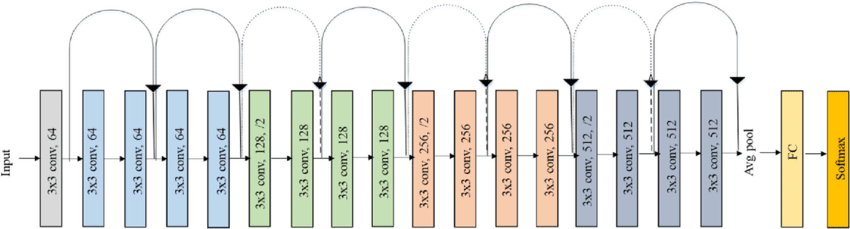

In [12]:
# Load a pre-trained ResNet model
pretrained_resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [13]:
num_classes = 2  # Replace with your actual number of classes
pretrained_resnet.fc = torch.nn.Linear(pretrained_resnet.fc.in_features, num_classes)

In [14]:
model = pretrained_resnet

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [16]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print training loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 0.7243940035400332
Epoch 2, Loss: 0.5429670881235698
Epoch 3, Loss: 0.4580154325813055
Epoch 4, Loss: 0.39316648974648266
Epoch 5, Loss: 0.31192804340151004
Epoch 6, Loss: 0.4285757764563209
Epoch 7, Loss: 0.3815549931901156
Epoch 8, Loss: 0.3338300598571535
Epoch 9, Loss: 0.26894781207207774
Epoch 10, Loss: 0.2591691752590361


In [17]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation data: {100 * correct / total}%")

Accuracy on validation data: 100.0%


###Observations:
1. Using simple CNN, the model achieved 81.8% accuracy.
2. Using resnet18, the model got 100% accuracy.

##Comparison:

###Simple CNN:
####Pros:
Simplicity: Simple to define and train.
####Cons:
Limited Capacity: Simple CNNs may not capture complex patterns and hierarchical features as effectively as deeper architectures like ResNet.
Limited Performance: For some tasks, a simple CNN may not achieve high accuracy due to its limited capacity.


###ResNet-18:
####Pros:
Deep Architecture: ResNet-18 is a deep convolutional neural network architecture that can capture complex hierarchical features in data.
Residual Blocks: Residual connections help mitigate the vanishing gradient problem, allowing for training very deep networks.
State-of-the-Art Performance: ResNet-18, pretrained on ImageNet, provides strong performance as a feature extractor.
####Cons:
Complexity: ResNet-18 has a more complex architecture, which may require more computational resources for training.





### Comparison Summary : The ResNet-18 model's superior performance is likely due to its deeper architecture, which can capture more intricate patterns and features in the data.

### Model Evaluation

In [19]:
import torch
from torchvision import transforms
from PIL import Image

# Define the same transform used for training and validation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the sample image and apply the same transform
sample_image_path = '/content/cotton/test/fresh cotton leaf/d (61)_iaip - Copy.jpg'
sample_image = Image.open(sample_image_path)
sample_image = transform(sample_image).unsqueeze(0)  # Add a batch dimension

# Load the trained model

# Create an instance of your model

model.eval()  # Set the model to evaluation mode

# Make predictions on the sample image
with torch.no_grad():
    output = model(sample_image)

# Assuming output is a tensor of shape (1, num_classes), where num_classes is the number of classes in your dataset
# You can convert it to class probabilities using softmax
import torch.nn.functional as F
probabilities = F.softmax(output, dim=1)

# Get the predicted class label
_, predicted_class = torch.max(output, 1)

# Define class names
class_names = ['Disease', 'Normal']

# Map the predicted class index to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f"The Predicted Class is : {predicted_class_name}")


The Predicted Class is : Normal


In [20]:
import torch
from torchvision import transforms
from PIL import Image

# Define the same transform used for training and validation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the sample image and apply the same transform
sample_image_path = '/content/cotton/train/diseased cotton leaf/dis_leaf (24)_iaip.jpg'
sample_image = Image.open(sample_image_path)
sample_image = transform(sample_image).unsqueeze(0)  # Add a batch dimension

# Load the trained model
# Create an instance of your model

model.eval()  # Set the model to evaluation mode

# Make predictions on the sample image
with torch.no_grad():
    output = model(sample_image)

# Assuming output is a tensor of shape (1, num_classes), where num_classes is the number of classes in your dataset
# You can convert it to class probabilities using softmax
import torch.nn.functional as F
probabilities = F.softmax(output, dim=1)

# Get the predicted class label
_, predicted_class = torch.max(output, 1)

# Define class names
class_names = ['Disease', 'Normal']

# Map the predicted class index to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f"The Predicted Class is : {predicted_class_name}")


The Predicted Class is : Disease
